[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/master/examples/sklearn/demo_new_features.ipynb)

# Getting Started

In [1]:
#Install AIF360
!pip install 'aif360'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

import sys
sys.path.append('../..')

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
# from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult, fetch_compas
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, statistical_parity_difference
from aif360.sklearn.metrics import generalized_fnr, difference

pip install 'aif360[FairAdapt]'
pip install 'aif360[LawSchoolGPA]'


## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [4]:
# X, y, sample_weight = fetch_adult(numeric_only=True)
X, y = fetch_compas(numeric_only=True)
X.head()

../../aif360/sklearn/datasets/utils.py:110: NumericConversionWarning: index contains non-numeric:
sex        int64
race    category
dtype: object
  category=NumericConversionWarning)


sex  age  age_cat  juv_fel_count  juv_misd_count  \
sex race                                                                 
0   Other               0   69        2              0               0   
    African-American    0   34        1              0               0   
    African-American    0   24        0              0               0   
    Other               0   44        1              0               0   
    Caucasian           0   41        1              0               0   

                      juv_other_count  priors_count  c_charge_degree  
sex race                                                              
0   Other                           0             0                1  
    African-American                0             0                1  
    African-American                1             4                1  
    Other                           0             0                0  
    Caucasian                       0            14                1

We can then map the protected attributes to integers,

In [5]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [6]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

Scale the dataset so that features are within [0, 1]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
X

sex       age  age_cat  juv_fel_count  juv_misd_count  \
sex race                                                          
0   5     0.0  0.653846      1.0            0.0             0.0   
    0     0.0  0.205128      0.5            0.0             0.0   
    0     0.0  0.076923      0.0            0.0             0.0   
    5     0.0  0.333333      0.5            0.0             0.0   
    2     0.0  0.294872      0.5            0.0             0.0   
...       ...       ...      ...            ...             ...   
    0     0.0  0.064103      0.0            0.0             0.0   
    0     0.0  0.064103      0.0            0.0             0.0   
    5     0.0  0.500000      1.0            0.0             0.0   
1   0     1.0  0.192308      0.5            0.0             0.0   
    3     1.0  0.064103      0.0            0.0             0.0   

          juv_other_count  priors_count  c_charge_degree  
sex race                                                  
0   5            0.000000      0.000000              1.0  
    0            0.000000      0.000000              1.0  
    0            0.111111      0.105263              1.0  
    5            0.000000      0.000000              0.0  
    2            0.000000      0.368421              1.0  
...                   ...           ...              ...  
    0            0.000000      0.000000              1.0  
    0            0.000000      0.000000              1.0  
    5            0.000000      0.000000              1.0  
1   0            0.000000      0.078947              0.0  
    3            0.000000      0.052632              1.0  

[6172 rows x 8 columns]

In [8]:
X.dropna(inplace=True)

split the dataset,

In [9]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

The protected attribute information is also replicated in the labels:

In [10]:
y_train.head()

sex  race
0    0       1
     2       1
     3       0
1    2       1
     2       0
dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [11]:
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6814254859611231

Now, we can analyze our predictions and quickly calucate the disparate impact for females vs. males:

In [12]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

3.811782165440702

In [13]:
statistical_parity_difference(y_test, y_pred, prot_attr='sex')

0.339067849361967

In [14]:
from aif360.sklearn.explainers.bias_explainer import explain_statistical_parity




c Decomposition for  sex = 0.0
c positive prediction probability of  sex = 0.0 is 0.44390243902439025
c sample shape: (3485, 8)
c sensitive group: sex = 0.0
c variance of Y 0.24685306365258772
c mean of Y 0.44390243902439025


/Users/bishwamittraghosh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/Users/bishwamittraghosh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/Users/bishwamittraghosh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/Users/bishwamittraghosh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"





c Decomposition for  sex = 1.0
c positive prediction probability of  sex = 1.0 is 0.11377245508982035
c sample shape: (835, 8)
c sensitive group: sex = 1.0
c variance of Y 0.10082828355265516
c mean of Y 0.11377245508982035

                              names        Sa  Sa_conf        Sb  Sb_conf  \
0                               sex  0.000000      0.0  0.000000      0.0   
1                               age  0.037718      0.0  0.003358      0.0   
2                           age_cat  0.010598      0.0  0.010708      0.0   
3                     juv_fel_count  0.000102      0.0  0.000242      0.0   
4                    juv_misd_count  0.000360      0.0 -0.001299      0.0   
..                              ...       ...      ...       ...      ...   
31      juv_misd_count/priors_count  0.001385      0.0 -0.000799      0.0   
32   juv_misd_count/c_charge_degree  0.001932      0.0 -0.000009      0.0   
33     juv_other_count/priors_count  0.001584      0.0 -0.000522      0.0   
34

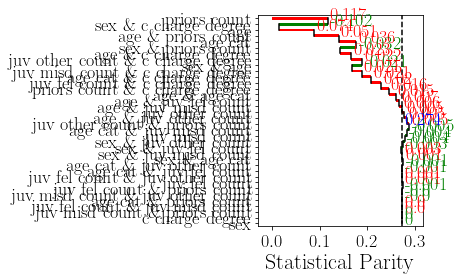

Exact statistical parity 0.3301299839345699


,weight
feature,
priors count,0.117061
sex \& c charge degree,-0.101842
age,0.073671
age \& priors count,0.051102
age cat,0.036233
sex \& priors count,-0.032465
age \& c charge degree,0.023052
juv other count \& c charge degree,0.022389
sex \& age,-0.021223


In [15]:
explain_statistical_parity(clf, X_train, sensitive_features=['sex'], maxorder=2, draw_plot=True, verbose=True)

In [19]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
prot_attr

array([1, 0, 1, ..., 0, 0, 1])

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [12]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.09875694175767563

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

If we wish to do something more complex, we can pass a custom array of protected attributes, like so (note: this choice of protected groups is just for demonstration):

In [13]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.3844295196608744

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [14]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'),
                     reweigher=Reweighing('sex'))

params = {'estimator__C': [1, 10]}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8402004864745338
{'estimator__C': 1}


In [15]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.5874230323221501

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [16]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=1234567)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.8345249502469226

In [17]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.1200164835077702

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [18]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [19]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.8200044224957618

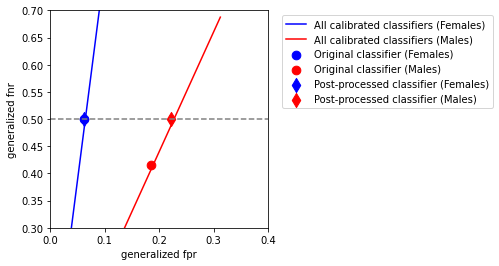

In [20]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.

We can quanitify the discrepancy between protected groups using the `difference` operator:

In [21]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

0.0006901337553552045